In [24]:
import time
#Ignore the next statement -- it is just to estimate how long the exercise takes
start = time.perf_counter()

In [25]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve, validation_curve, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance

In [27]:
np.random.seed(903967645)

In [5]:
phishing_dataset = pd.read_csv('../data/phishing_dataset.csv')
print(phishing_dataset.info())
phishing_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   index                        11055 non-null  int64
 1   having_IPhaving_IP_Address   11055 non-null  int64
 2   URLURL_Length                11055 non-null  int64
 3   Shortining_Service           11055 non-null  int64
 4   having_At_Symbol             11055 non-null  int64
 5   double_slash_redirecting     11055 non-null  int64
 6   Prefix_Suffix                11055 non-null  int64
 7   having_Sub_Domain            11055 non-null  int64
 8   SSLfinal_State               11055 non-null  int64
 9   Domain_registeration_length  11055 non-null  int64
 10  Favicon                      11055 non-null  int64
 11  port                         11055 non-null  int64
 12  HTTPS_token                  11055 non-null  int64
 13  Request_URL                  11055 non-null  i

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [6]:
# no null data
print(phishing_dataset.shape)
phishing_dataset.isna().any().any()

(11055, 32)


False

In [7]:
# Separate features and target
X = phishing_dataset.drop(columns=['Result'])
y = phishing_dataset['Result']

# Normalize the feature data
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

# Convert back to DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

In [8]:
%%time
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    strat_train_set = X.iloc[train_index]
    strat_test_set = X.iloc[test_index]
    strat_train_labels = y.iloc[train_index]
    strat_test_labels = y.iloc[test_index]

train_X = strat_train_set
test_X = strat_test_set
train_y = strat_train_labels
test_y = strat_test_labels

CPU times: user 4.25 ms, sys: 1.47 ms, total: 5.72 ms
Wall time: 4.53 ms


In [11]:
%%time
# SVM Classifier
svm = SVC(gamma='auto', kernel='poly', class_weight='balanced')
svm.fit(train_X, train_y)
print(svm.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
CPU times: user 543 ms, sys: 17.7 ms, total: 560 ms
Wall time: 559 ms


In [12]:
print("Classes:", svm.classes_)
print("Support Vectors Indices:", svm.support_)
print("Support Vectors:", svm.support_vectors_)
print("Number of Support Vectors for Each Class:", svm.n_support_)
print("Coefficients of Support Vectors in Decision Function:", svm.dual_coef_)

# The following attribute is only available if the kernel is linear
if svm.kernel == 'linear':
    print("Weights assigned to the features:", svm.coef_)

Classes: [-1  1]
Support Vectors Indices: [   0    1    6 ... 8821 8833 8836]
Support Vectors: [[0.15903745 1.         0.         ... 1.         0.5        1.        ]
 [0.98697304 1.         0.         ... 1.         0.5        1.        ]
 [0.37814366 0.         0.         ... 1.         0.5        0.        ]
 ...
 [0.12755564 0.         0.         ... 1.         0.         0.        ]
 [0.04468971 1.         0.         ... 1.         1.         1.        ]
 [0.03889995 1.         0.         ... 0.         0.5        1.        ]]
Number of Support Vectors for Each Class: [1033 1301]
Coefficients of Support Vectors in Decision Function: [[-1.12863706 -0.60892403 -1.12863706 ...  0.89768575  0.89768575
   0.89768575]]


In [13]:
%%time
# Evaluate on training data
train_predictions = svm.predict(train_X)
train_accuracy = accuracy_score(train_y, train_predictions)
train_roc_auc = roc_auc_score(train_y, train_predictions)
train_precision = precision_score(train_y, train_predictions)
train_recall = recall_score(train_y, train_predictions)
train_f1 = f1_score(train_y, train_predictions)

print("Training Accuracy:", train_accuracy)
print("Training ROC AUC Score:", train_roc_auc)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1)
train_report = classification_report(train_y, train_predictions)
print(train_report)

# Write to a text file
with open('../results/phishing-svm/training_metrics_report.txt', 'w') as file:
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Training ROC AUC Score: " + str(train_roc_auc) + "\n")
    file.write("Training Precision: " + str(train_precision) + "\n")
    file.write("Training Recall: " + str(train_recall) + "\n")
    file.write("Training F1 Score: " + str(train_f1) + "\n")
    file.write("\nClassification Report:\n")
    file.write(train_report + "\n")

Training Accuracy: 0.9337403889642696
Training ROC AUC Score: 0.9323460414750869
Training Precision: 0.936971405557793
Training Recall: 0.9445797807551766
Training F1 Score: 0.940760210270926
              precision    recall  f1-score   support

          -1       0.93      0.92      0.92      3918
           1       0.94      0.94      0.94      4926

    accuracy                           0.93      8844
   macro avg       0.93      0.93      0.93      8844
weighted avg       0.93      0.93      0.93      8844

CPU times: user 375 ms, sys: 3.39 ms, total: 378 ms
Wall time: 378 ms


In [14]:
%%time
# Evaluate on testing data
test_predictions = svm.predict(test_X)
test_accuracy = accuracy_score(test_y, test_predictions)
test_roc_auc = roc_auc_score(test_y, test_predictions)
test_precision = precision_score(test_y, test_predictions)
test_recall = recall_score(test_y, test_predictions)
test_f1 = f1_score(test_y, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing ROC AUC Score:", test_roc_auc)
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)
print("Testing F1 Score:", test_f1)
test_report = classification_report(test_y, test_predictions)
print(test_report)

# Write to a text file
with open('../results/phishing-svm/testing_metrics_report.txt', 'w') as file:
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Testing ROC AUC Score: " + str(test_roc_auc) + "\n")
    file.write("Testing Precision: " + str(test_precision) + "\n")
    file.write("Testing Recall: " + str(test_recall) + "\n")
    file.write("Testing F1 Score: " + str(test_f1) + "\n")
    file.write("\nClassification Report:\n")
    file.write(test_report + "\n")

Testing Accuracy: 0.9312528267752148
Testing ROC AUC Score: 0.9296270660985758
Testing Precision: 0.9333333333333333
Testing Recall: 0.9439480097481722
Testing F1 Score: 0.938610662358643
              precision    recall  f1-score   support

          -1       0.93      0.92      0.92       980
           1       0.93      0.94      0.94      1231

    accuracy                           0.93      2211
   macro avg       0.93      0.93      0.93      2211
weighted avg       0.93      0.93      0.93      2211

CPU times: user 115 ms, sys: 2.13 ms, total: 117 ms
Wall time: 116 ms


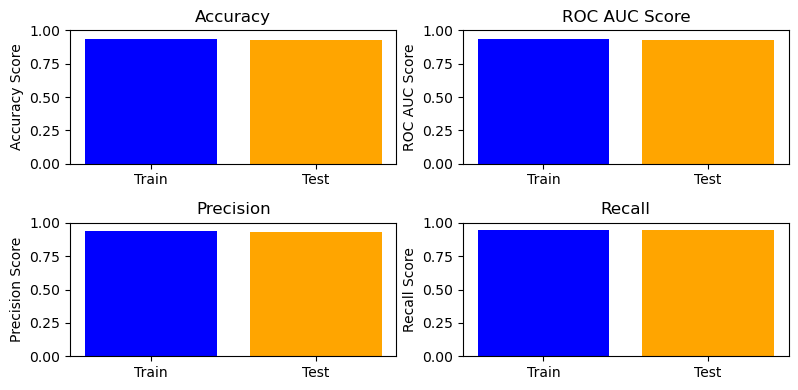

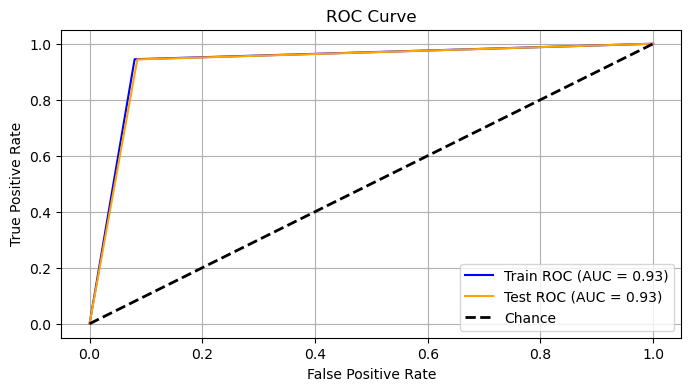

CPU times: user 649 ms, sys: 180 ms, total: 829 ms
Wall time: 1.27 s


In [36]:
%%time
fig, ax = plt.subplots(2, 2, figsize=(8, 4))

# Accuracy
ax[0, 0].bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel('Accuracy Score')

# ROC AUC Score
ax[0, 1].bar(['Train', 'Test'], [train_roc_auc, test_roc_auc], color=['blue', 'orange'])
ax[0, 1].set_title('ROC AUC Score')
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_ylabel('ROC AUC Score')

# Precision
ax[1, 0].bar(['Train', 'Test'], [train_precision, test_precision], color=['blue', 'orange'])
ax[1, 0].set_title('Precision')
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_ylabel('Precision Score')

# Recall
ax[1, 1].bar(['Train', 'Test'], [train_recall, test_recall], color=['blue', 'orange'])
ax[1, 1].set_title('Recall')
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_ylabel('Recall Score')

plt.tight_layout()
fig.savefig('../images/phishing-svm/metrics-comparison.png')
plt.show()

# Plotting  ROC Curves
train_fpr, train_tpr, _ = roc_curve(train_y, train_predictions)
test_fpr, test_tpr, _ = roc_curve(test_y, test_predictions)

plt.figure(figsize=(8, 4))
plt.plot(train_fpr, train_tpr, label=f'Train ROC (AUC = {auc(train_fpr, train_tpr):.2f})', color='blue')
plt.plot(test_fpr, test_tpr, label=f'Test ROC (AUC = {auc(test_fpr, test_tpr):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/phishing-svm/roc-curve-fpr-tpr')
plt.show()

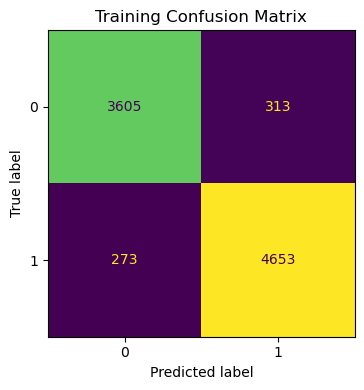

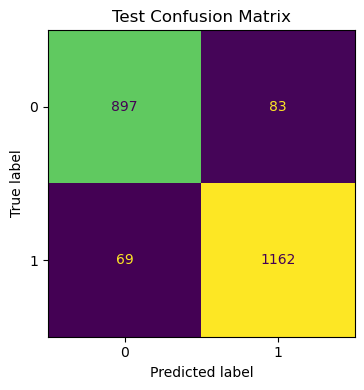

CPU times: user 811 ms, sys: 47.5 ms, total: 858 ms
Wall time: 1.45 s


In [37]:
%%time
# Plot and save Training Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
train_cm = confusion_matrix(train_y, train_predictions)
ConfusionMatrixDisplay(train_cm).plot(ax=ax, colorbar=False)
ax.set_title("Training Confusion Matrix")
plt.tight_layout()
plt.savefig('../images/phishing-svm/training-cm.png')
plt.show()

# Plot and save Test Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
test_cm = confusion_matrix(test_y, test_predictions)
ConfusionMatrixDisplay(test_cm).plot(ax=ax, colorbar=False)
ax.set_title('Test Confusion Matrix')
plt.tight_layout()
plt.savefig('../images/phishing-svm/testing-cm.png')
plt.show()

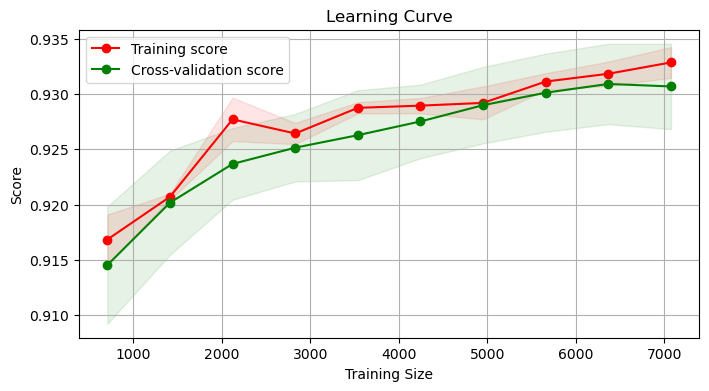

CPU times: user 16.5 s, sys: 192 ms, total: 16.7 s
Wall time: 33.8 s


In [38]:
%%time
train_sizes, train_scores, test_scores = learning_curve(svm, train_X, train_y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/phishing-svm/learning-curve-training-size.png')
plt.show()

Shape of train_X: (8844, 31)
Shape of y: (8844,)


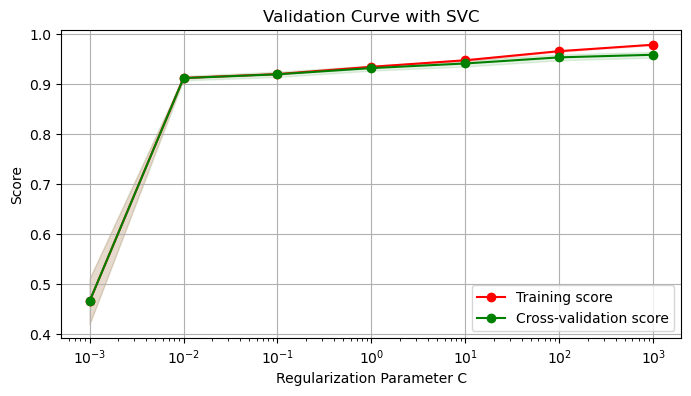

CPU times: user 852 ms, sys: 33.6 ms, total: 886 ms
Wall time: 9.17 s


In [16]:
%%time
# Check the shape of train_X and y
print(f'Shape of train_X: {train_X.shape}')
print(f'Shape of y: {train_y.shape}')

# Ensure train_X and y have the same number of samples
assert train_X.shape[0] == train_y.shape[0], "Mismatch in number of samples between train_X and y"

# Example range for the regularization parameter C
param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Compute validation curve
train_scores, test_scores = validation_curve(SVC(gamma='auto', class_weight='balanced'), 
                                             train_X, train_y, 
                                             param_name="C", 
                                             param_range=param_range, 
                                             cv=5, 
                                             scoring='accuracy', 
                                             n_jobs=-1)

# Calculate mean and standard deviation for training and testing scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, 'o-', color='r', label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.title('Validation Curve with SVC')
plt.xlabel('Regularization Parameter C')
plt.ylabel('Score')
plt.xscale('log')  # Use logarithmic scale for better visualization
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/phishing-svm/validation-curve-C.png')
plt.show()

In [40]:
%%time
# Perform 10-fold cross-validation
cv_scores = cross_val_score(svm, train_X, train_y, cv=10, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("mean cross-validation score:", cv_scores.mean())

# Write cross-validation scores to a text file
with open('../results/phishing-svm/cross_validation_scores.txt', 'w') as file:
    file.write("Cross-validation scores: " + np.array2string(cv_scores) + "\n")
    file.write("Mean cross-validation score: " + str(cv_scores.mean()) + "\n")

Cross-validation scores: [0.92881356 0.94011299 0.9220339  0.93785311 0.91742081 0.93665158
 0.92986425 0.92873303 0.9321267  0.94343891]
mean cross-validation score: 0.9317048853439681
CPU times: user 4.85 s, sys: 87 ms, total: 4.93 s
Wall time: 9.31 s


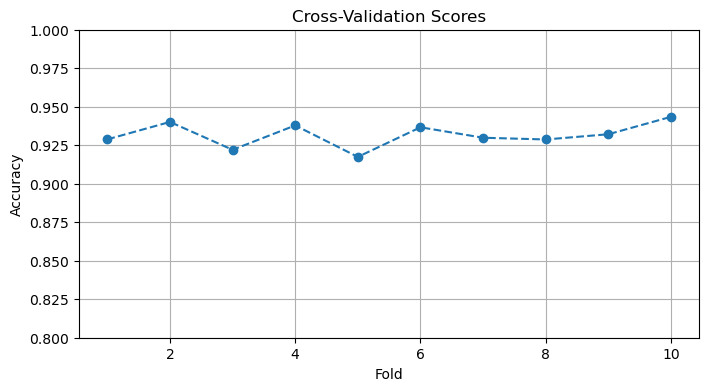

In [41]:
# Plot cross-validation scores
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='--')
plt.title('Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.grid(True)
plt.savefig('../images/phishing-svm/cross-validation-scores.png')
plt.show()

              precision    recall  f1-score   support

          -1       0.93      0.92      0.92      3918
           1       0.93      0.94      0.94      4926

    accuracy                           0.93      8844
   macro avg       0.93      0.93      0.93      8844
weighted avg       0.93      0.93      0.93      8844



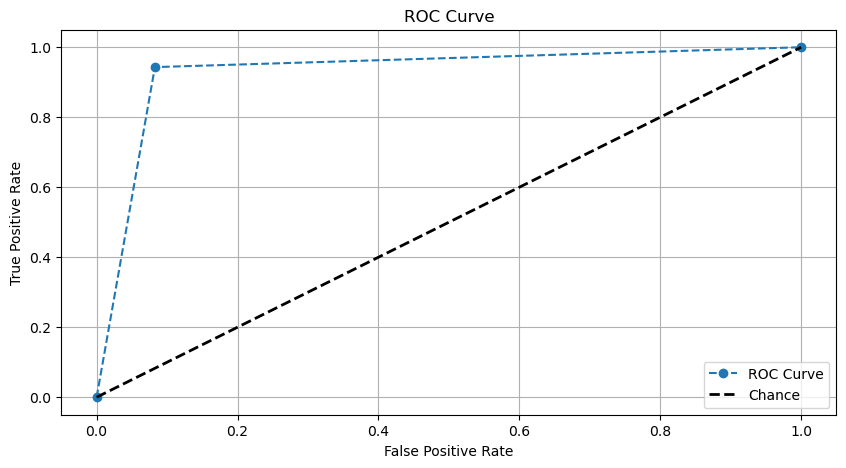

CPU times: user 5.22 s, sys: 71.1 ms, total: 5.29 s
Wall time: 9.14 s


In [42]:
%%time
y_pred = cross_val_predict(svm, train_X, train_y, cv=10)

report = classification_report(train_y, y_pred)
print(report)

with open('../results/phishing-svm/classification_report.txt', 'w') as file:
    file.write(report)

fpr, tpr, thresholds = roc_curve(train_y, y_pred, pos_label=1)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, marker='o', linestyle='--', label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/phishing-svm/roc-curve-fpr.png')
plt.show()

In [43]:
%%time
# Initialize the SVC
svc = SVC(class_weight='balanced')

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']  # Kernel type
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV on the training data
grid_search.fit(train_X, train_y)

# Print the best parameters and best score found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Write the best parameters and best score to a text file
with open('../results/phishing-svm/grid_search_results.txt', 'w') as file:
    file.write("Best parameters found: " + str(grid_search.best_params_) + "\n")
    file.write("Best cross-validation score: " + str(grid_search.best_score_) + "\n")

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Best parameters found:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score:  0.9637048566437054
CPU times: user 1.11 s, sys: 272 ms, total: 1.38 s
Wall time: 2min 56s


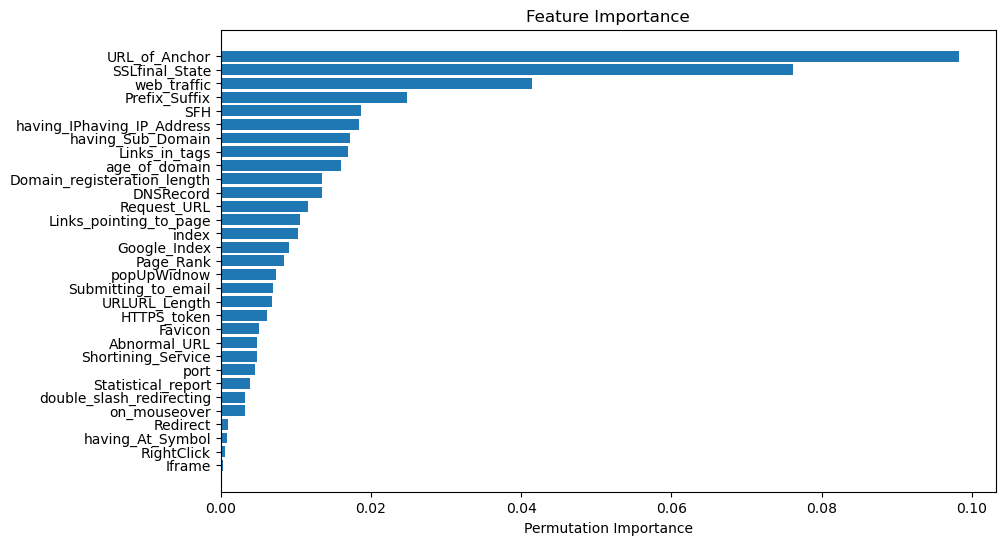

CPU times: user 34.6 s, sys: 267 ms, total: 34.8 s
Wall time: 1min 15s


In [44]:
%%time
best_svm = grid_search.best_estimator_
best_svm.fit(train_X, train_y)

result = permutation_importance(best_svm, test_X, test_y, n_repeats=10, random_state=42, n_jobs=1)

# Plot feature importance
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(train_X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.savefig('../images/phishing-svm/feature-importance.png')
plt.show()

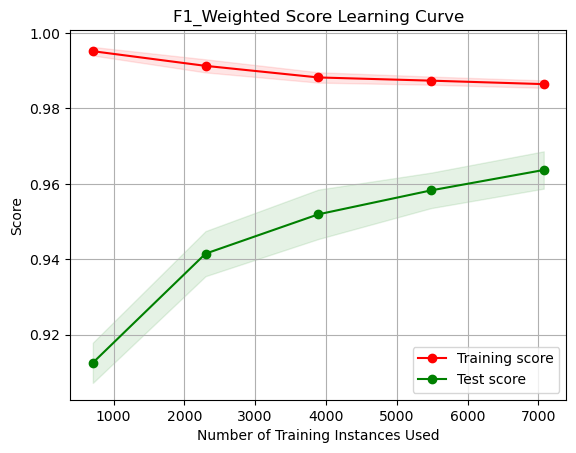

              precision    recall  f1-score   support

          -1    0.92857   0.91531   0.92189       980
           1    0.93333   0.94395   0.93861      1231

    accuracy                        0.93125      2211
   macro avg    0.93095   0.92963   0.93025      2211
weighted avg    0.93122   0.93125   0.93120      2211

[[ 897   83]
 [  69 1162]]
CPU times: user 341 ms, sys: 18.2 ms, total: 359 ms
Wall time: 1.41 s


In [15]:
%%time
# Initialize the SVC with the best parameters found by GridSearchCV
best_svc = SVC(C=100, gamma='scale', kernel='rbf', class_weight='balanced')

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(best_svc, train_X, train_y, cv=5, scoring='f1_weighted', n_jobs=-1)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.title("F1_Weighted Score Learning Curve")
plt.xlabel("Number of Training Instances Used")
plt.ylabel("Score")
plt.grid()

# Plot training scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")

# Plot test scores
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend(loc="best")
plt.savefig('../images/phishing-svm/best-svc-f1-isntances.png')
plt.show()

# Print classification report and confusion matrix
print(classification_report(test_y, test_predictions, digits=5))
print(confusion_matrix(test_y, test_predictions))

# Write to a text file
with open('../results/phishing-svm/test_classification_results.txt', 'w') as file:
    file.write("Classification Report:\n")
    file.write(classification_report(test_y, test_predictions, digits=5) + "\n")
    file.write("Confusion Matrix:\n")
    file.write(np.array2string(confusion_matrix(test_y, test_predictions)) + "\n")

# Plotting the results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
test_metrics = [test_accuracy, test_precision, test_recall, test_f1]



In [46]:
end = time.perf_counter()
print("Time taken: in min", (end - start)/60)

Time taken: in min 5.660675646516665
